## Simiplified Analysis

In [7]:
import random
random.seed(0)
import json

def analysis(data:dict, verbose:bool=False, round_cut=-1):
    """Analyze the data and print out the results

    Args:
        data (dict): The data to be analyzed, load an "agent log" json file
        
    """
    if round_cut != -1 and "trials" in data[0]:
        print("Warning: use round_cut with trial data")
    total_len = len(data)
    total_reward = 0
    total_round = 0
    
    success_count = 0 # reward == 1
    non_zero_reward_count = 0 # reward > 0
    submit_count = 0

    path_count = {}
    reward_count = {} # reward for each difficulty
    round_count = {}
    eval_error_count = 0

    # cost
    total_cost = 0
    total_prompt_tokens = 0
    total_completion_tokens = 0

    # query efficiency
    empty_result_count = 0
    error_query_count = 0
    query_count = 0

    success_non_empty_query_count = 0
    potential_good_example_count = 0

    fail_to_run_count = 0
    max_round = 0
    min_round = 1000

    for k in data:
        if k.get("usage_summary") is None:
            fail_to_run_count += 1
            continue

        p = len(k['question_dict']['shortest_alert_path'])
        if p not in path_count:
            path_count[p] = 0
            reward_count[p] = 0
            round_count[p] = 0

        # total
        tmp_round = (len(k["messages"]) - 1) // 2
        total_round += tmp_round

        if round_cut != -1 and tmp_round > round_cut:
            # print(f"Cutting off at round {round_cut}")
            k['reward'] = 0

        total_reward += k['reward']
        if k['reward'] > 0:
            non_zero_reward_count += 1
        if k['reward'] == 1:
            success_count += 1

        path_count[p] += 1
        reward_count[p] += k['reward']

        if "trials" in k:
            for _, t in k["trials"].items():
                total_cost, total_prompt_tokens, total_completion_tokens = add_to_usage(t['usage_summary'], total_cost, total_prompt_tokens, total_completion_tokens)
        else:
            total_cost, total_prompt_tokens, total_completion_tokens = add_to_usage(k['usage_summary'], total_cost, total_prompt_tokens, total_completion_tokens)

            
    if verbose:
        print(f"Average reward: {total_reward}/{total_len} = {round(total_reward/total_len,6)}")
        print(f"Average round: {total_round}/{total_len} = {round(total_round/total_len,6)}")


    return {
        "total_len": total_len,

        # Performance Analysis
        "total_reward": total_reward,
        "success_count": success_count, # reward==1
        "non_zero_reward_count": non_zero_reward_count, # for evaluator usefullness
        "submit_count": submit_count,

        # Efficiency / Computational Analysis
        "total_cost": total_cost,
        "total_prompt_tokens": total_prompt_tokens,
        "total_completion_tokens": total_completion_tokens,

        # Query Efficiency
        "empty_result_count": empty_result_count,
        "error_query_count": error_query_count,
        "query_count": query_count,

        # Evaluation Analysis
        "eval_error_count": eval_error_count,
        "fail_to_run_count": fail_to_run_count
    }

def add_to_usage(usage_summary:dict, total_cost=0, total_prompt_tokens=0, total_completion_tokens=0):
    model = list(usage_summary.keys())[-1]
    total_cost += usage_summary[model]['cost']
    total_prompt_tokens += usage_summary[model]['prompt_tokens']
    total_completion_tokens += usage_summary[model]['completion_tokens']
    return total_cost, total_prompt_tokens, total_completion_tokens    

def print_analysis(result_dict:dict, head:str=None):
    print("*"*40)
    if head:
        print(f"{head} analysis")
    problem_count = result_dict['total_len']

    print(f"Average reward: {result_dict['total_reward']}/{problem_count} = {round(result_dict['total_reward']/problem_count,4)}")
    print(f"Success rate: {result_dict['success_count']}/{problem_count} = {round(result_dict['success_count']/problem_count * 100,2)}%")
    
    # Computational Analysis
    print(f"** Computational Analysis:")
    print(f"Average round: {result_dict['total_round']}/{problem_count} = {round(result_dict['total_round']/problem_count,4)}")
    print(f"Average cost: {result_dict['total_cost']}/{problem_count} = {round(result_dict['total_cost']/problem_count,4)}")
    print(f"Average prompt tokens: {result_dict['total_prompt_tokens']}/{problem_count} = {round(result_dict['total_prompt_tokens']/problem_count,4)}")
    print(f"Average completion tokens: {result_dict['total_completion_tokens']}/{problem_count} = {round(result_dict['total_completion_tokens']/problem_count,4)}")

    print("** Query Efficiency: ")
    success_query_count = result_dict['query_count'] - result_dict['error_query_count']
    print(f'Success Query rate: {success_query_count}/{result_dict["query_count"]} = {round(success_query_count/result_dict["query_count"] * 100,2)}%')
    print(f'Success Non-Empty Query rate: {success_query_count-result_dict["empty_result_count"]}/{result_dict["query_count"]} = {round((success_query_count-result_dict["empty_result_count"])/result_dict["query_count"] * 100,2)}%')
    
    print(f"Potential Good Example Count: {result_dict['potential_good_example_count']} / {problem_count}")
    print(f"Fail to run count: {result_dict['fail_to_run_count']}")

def get_correct_problem_ids(log_path, file_template, incident_id):
    a = open(f"{log_path}/{file_template.format(incident_id)}", "r")
    b = json.load(a)
    correct_ids = []
    for k in b:
        if k['reward'] == 1:
            correct_ids.append(k['question_id'])
    return correct_ids



def get_over_leaf_format(log_path, file_folder, round_cut=-1):
    file_template = f"{log_path}/{file_folder}" + "/agent_incident_{0}.json"

    total_count = 0
    total_reward = 0
    total_success_count = 0
    total_cost = 0
    total_prompt_tokens = 0
    total_completion_tokens = 0

    accs_str = ""

    incidents = [5, 34, 38, 39, 55, 134, 166, 322]
    for i in incidents:
        # print(f"Analysis for incident {i}")
        with open(file_template.format(i), "r") as f:
            data = json.load(f)
        result = analysis(data, False, round_cut=round_cut)
        accs_str += "& " + str(round(result['total_reward']/result['total_len'], 3)) + " "

        total_count += result['total_len']
        total_reward += result['total_reward']
        total_success_count += result['success_count']
        total_cost += result['total_cost']
        total_prompt_tokens += result['total_prompt_tokens']
        total_completion_tokens += result['total_completion_tokens']
    
    accs_str += "& " + str(round(total_reward/total_count, 3)) + " "
    print(total_count)
    # accs_str += "& " + str(round(total_cost/total_count, 3)) + " "
    print(accs_str)
    return round(total_reward/total_count, 3)

In [14]:
baselines = [
    "BaselineAgent_gpt-4o_c70_alert_level_t0_s25_trial1",
    "BaselineAgent_4o-mini_c71_alert_level_t0_s25_trial1",
    "BaselineAgent_o1-mini_c92_alert_level_t0_s25_trial1",
    "BaselineAgent_o3-mini_c99_alert_level_t0_s25_trial1"
]

log_path = "../secgym/final_results"

for b in baselines:
    print(b)
    get_over_leaf_format(log_path, b)

BaselineAgent_gpt-4o_c70_alert_level_t0_s25_trial1
589
& 0.357 & 0.322 & 0.273 & 0.279 & 0.215 & 0.491 & 0.172 & 0.321 & 0.296 
BaselineAgent_4o-mini_c71_alert_level_t0_s25_trial1
589
& 0.198 & 0.205 & 0.273 & 0.191 & 0.184 & 0.228 & 0.179 & 0.375 & 0.214 
BaselineAgent_o1-mini_c92_alert_level_t0_s25_trial1
589
& 0.182 & 0.278 & 0.182 & 0.226 & 0.164 & 0.333 & 0.205 & 0.418 & 0.24 
BaselineAgent_o3-mini_c99_alert_level_t0_s25_trial1
589
& 0.359 & 0.293 & 0.273 & 0.261 & 0.236 & 0.404 & 0.262 & 0.36 & 0.301 


In [13]:
mmbaselines = [
    "MultiModelBaselineAgent_master_o1_mini_slave_gpt-4o_c96_alert_level_t0_s25_trial1",
    "MultiModelBaselineAgent_master_o1_slave_gpt-4o_c98_alert_level_t0_s25_trial1",
    "MultiModelBaselineAgent_master_o3_mini_slave_gpt-4o_c100_alert_level_t0_s25_trial1"
]

for b in mmbaselines:
    print(b)
    get_over_leaf_format(log_path, b)

MultiModelBaselineAgent_master_o1_mini_slave_gpt-4o_c96_alert_level_t0_s25_trial1
589
& 0.263 & 0.278 & 0.273 & 0.232 & 0.297 & 0.316 & 0.239 & 0.411 & 0.281 
MultiModelBaselineAgent_master_o1_slave_gpt-4o_c98_alert_level_t0_s25_trial1
589
& 0.363 & 0.31 & 0.091 & 0.276 & 0.301 & 0.47 & 0.234 & 0.458 & 0.326 
MultiModelBaselineAgent_master_o3_mini_slave_gpt-4o_c100_alert_level_t0_s25_trial1
589
& 0.416 & 0.32 & 0.273 & 0.303 & 0.296 & 0.34 & 0.253 & 0.392 & 0.327 


In [18]:
tab2_4o = [
    "BaselineAgent_gpt-4o_c70_alert_level_t0_s25_trial1",
    "PromptSauceAgent_gpt-4o_c83_alert_level_t0_s15_trial2",
    "ReflexionAgent_gpt-4o_c82_alert_level_t0_s15_trial3"
]

tab2_4o_mini = [
    "BaselineAgent_4o-mini_c71_alert_level_t0_s25_trial1",
    "PromptSauceAgent_4o-mini_c79_alert_level_t0_s15_trial2",
    "ReflexionAgent_4o-mini_c80_alert_level_t0_s15_trial3"
]

for b in tab2_4o:
    print(b)
    get_over_leaf_format(log_path, b, round_cut=15)

print("-"*40)
for b in tab2_4o_mini:
    print(b)
    get_over_leaf_format(log_path, b, round_cut=15)

BaselineAgent_gpt-4o_c70_alert_level_t0_s25_trial1
589
& 0.308 & 0.298 & 0.273 & 0.238 & 0.212 & 0.421 & 0.126 & 0.286 & 0.26 
PromptSauceAgent_gpt-4o_c83_alert_level_t0_s15_trial2
589
& 0.257 & 0.339 & 0.273 & 0.363 & 0.274 & 0.246 & 0.303 & 0.375 & 0.306 
ReflexionAgent_gpt-4o_c82_alert_level_t0_s15_trial3
589
& 0.469 & 0.537 & 0.455 & 0.417 & 0.344 & 0.463 & 0.379 & 0.606 & 0.447 
----------------------------------------
BaselineAgent_4o-mini_c71_alert_level_t0_s25_trial1
589
& 0.147 & 0.193 & 0.273 & 0.15 & 0.144 & 0.211 & 0.129 & 0.311 & 0.175 
PromptSauceAgent_4o-mini_c79_alert_level_t0_s15_trial2
589
& 0.294 & 0.39 & 0.182 & 0.196 & 0.185 & 0.193 & 0.246 & 0.268 & 0.251 
ReflexionAgent_4o-mini_c80_alert_level_t0_s15_trial3
589
& 0.433 & 0.488 & 0.182 & 0.459 & 0.26 & 0.491 & 0.492 & 0.539 & 0.435 


In [52]:
get_over_leaf_format(log_path, "ReflexionAgent_gpt-4o_c82_alert_level_t0_s15_trial3")

& 0.48 & 0.541 & 0.417 & 0.429 & 0.344 & 0.472 & 0.379 & 0.613 & 0.453 & 1.134 


0.453

In [53]:
get_over_leaf_format(log_path, "BaselineAgent_4o-mini_c71_alert_level_t0_s25_trial1")

& 0.194 & 0.209 & 0.25 & 0.197 & 0.184 & 0.241 & 0.179 & 0.386 & 0.217 & 0.009 


0.217

In [54]:
get_over_leaf_format(log_path, "BaselineAgent_4o-mini_c71_alert_level_t0_s25_trial1", round_cut=15)

& 0.144 & 0.198 & 0.25 & 0.157 & 0.144 & 0.224 & 0.129 & 0.323 & 0.179 & 0.009 


0.179

In [55]:
get_over_leaf_format(log_path, "BaselineAgent_gpt-4o_c70_alert_level_t0_s25_trial1", round_cut=15)

& 0.312 & 0.311 & 0.25 & 0.233 & 0.212 & 0.414 & 0.126 & 0.298 & 0.262 & 0.464 


0.262

In [56]:
get_over_leaf_format(log_path, "PromptSauceAgent_gpt-4o_c72_alert_level_t0_s25_trial1", round_cut=15)

& 0.304 & 0.435 & 0.333 & 0.326 & 0.168 & 0.276 & 0.287 & 0.34 & 0.302 & 0.553 


0.302

In [57]:
get_over_leaf_format(log_path, "PromptSauceAgent_4o-mini_c73_alert_level_t0_s25_trial1", round_cut=15)

& 0.224 & 0.351 & 0.283 & 0.237 & 0.153 & 0.241 & 0.257 & 0.27 & 0.244 & 0.016 


0.244

## Combine trials to get Best of 3 trials for baseline

In [15]:

def combine_results(t2step15_data, t1step25data, round_cut=-1):
    total_count = 0
    total_reward = 0

    for i in range(len(t2step15_data)):
        d1 = t2step15_data[i]
        d2 = t1step25data[i]
        if d1.get("usage_summary") is None or d2.get("usage_summary") is None:
            print(f"Missing usage summary for {i}")
            continue
        if round_cut != -1 and (len(d2["messages"]) - 1) // 2 > round_cut:
            # print(f"Cutting off at round {round_cut}")
            d2['reward'] = 0
        total_reward += max(d1['reward'], d2['reward']) # best of 3
        total_count += 1

    return {
        "total_len": total_count,
        "total_reward": total_reward
    }


def get_over_leaf_format_for_2(log_path, t2step15_file, t1step25_file, round_cut=-1):
    t2step15_file_template = f"{log_path}/{t2step15_file}" + "/agent_incident_{0}.json"
    t1step25_file_template = f"{log_path}/{t1step25_file}" + "/agent_incident_{0}.json"

    total_count = 0
    total_reward = 0
    accs_str = ""

    incidents = [5, 34, 38, 39, 55, 134, 166, 322]
    for i in incidents:
        # print(f"Analysis for incident {i}")
        with open(t2step15_file_template.format(i), "r") as f:
            data1 = json.load(f)
        with open(t1step25_file_template.format(i), "r") as f:
            data2 = json.load(f)

        result = combine_results(data1, data2, round_cut=round_cut)
        accs_str += "& " + str(round(result['total_reward']/result['total_len'], 3)) + " "

        total_count += result['total_len']
        total_reward += result['total_reward']
    
    accs_str += "& " + str(round(total_reward/total_count, 3)) + " "
    print(accs_str)


get_over_leaf_format_for_2(log_path, 
                           "PromptSauceAgent_4o-mini_c79_alert_level_t0_s15_trial2",
                           "PromptSauceAgent_4o-mini_c73_alert_level_t0_s25_trial1",
                           round_cut=15)
    

& 0.359 & 0.51 & 0.4 & 0.301 & 0.237 & 0.333 & 0.366 & 0.382 & 0.351 


In [16]:
get_over_leaf_format_for_2(log_path, 
                           "PromptSauceAgent_gpt-4o_c83_alert_level_t0_s15_trial2",
                           "PromptSauceAgent_gpt-4o_c72_alert_level_t0_s25_trial1",
                           round_cut=15)

& 0.353 & 0.48 & 0.364 & 0.455 & 0.348 & 0.368 & 0.407 & 0.471 & 0.408 


## GPT-4o and GPT-4o-mini with responding to steps

In [64]:
gpt4omini_results = []
for r in [5, 10, 15, 20, 25]:
    avg_reward = get_over_leaf_format(log_path, "BaselineAgent_4o-mini_c71_alert_level_t0_s25_trial1", round_cut=r)
    gpt4omini_results.append(avg_reward)

& 0.02 & 0.024 & 0.083 & 0.02 & 0.014 & 0.017 & 0.023 & 0.035 & 0.022 & 0.009 
& 0.074 & 0.174 & 0.083 & 0.12 & 0.074 & 0.138 & 0.101 & 0.236 & 0.122 & 0.009 
& 0.144 & 0.198 & 0.25 & 0.157 & 0.144 & 0.224 & 0.129 & 0.323 & 0.179 & 0.009 
& 0.194 & 0.209 & 0.25 & 0.181 & 0.184 & 0.241 & 0.179 & 0.376 & 0.213 & 0.009 
& 0.194 & 0.209 & 0.25 & 0.197 & 0.184 & 0.241 & 0.179 & 0.386 & 0.217 & 0.009 


In [65]:
gpt40_results = []
for r in [5, 10, 15, 20, 25]:
    avg_reward = get_over_leaf_format(log_path, "BaselineAgent_gpt-4o_c70_alert_level_t0_s25_trial1", round_cut=r)
    gpt40_results.append(avg_reward)

& 0.1 & 0.129 & 0.0 & 0.112 & 0.03 & 0.069 & 0.034 & 0.105 & 0.08 & 0.464 
& 0.202 & 0.24 & 0.083 & 0.182 & 0.182 & 0.31 & 0.103 & 0.228 & 0.197 & 0.464 
& 0.312 & 0.311 & 0.25 & 0.233 & 0.212 & 0.414 & 0.126 & 0.298 & 0.262 & 0.464 
& 0.35 & 0.311 & 0.25 & 0.243 & 0.212 & 0.483 & 0.161 & 0.333 & 0.285 & 0.464 
& 0.37 & 0.334 & 0.25 & 0.273 & 0.215 & 0.483 & 0.172 & 0.333 & 0.299 & 0.464 


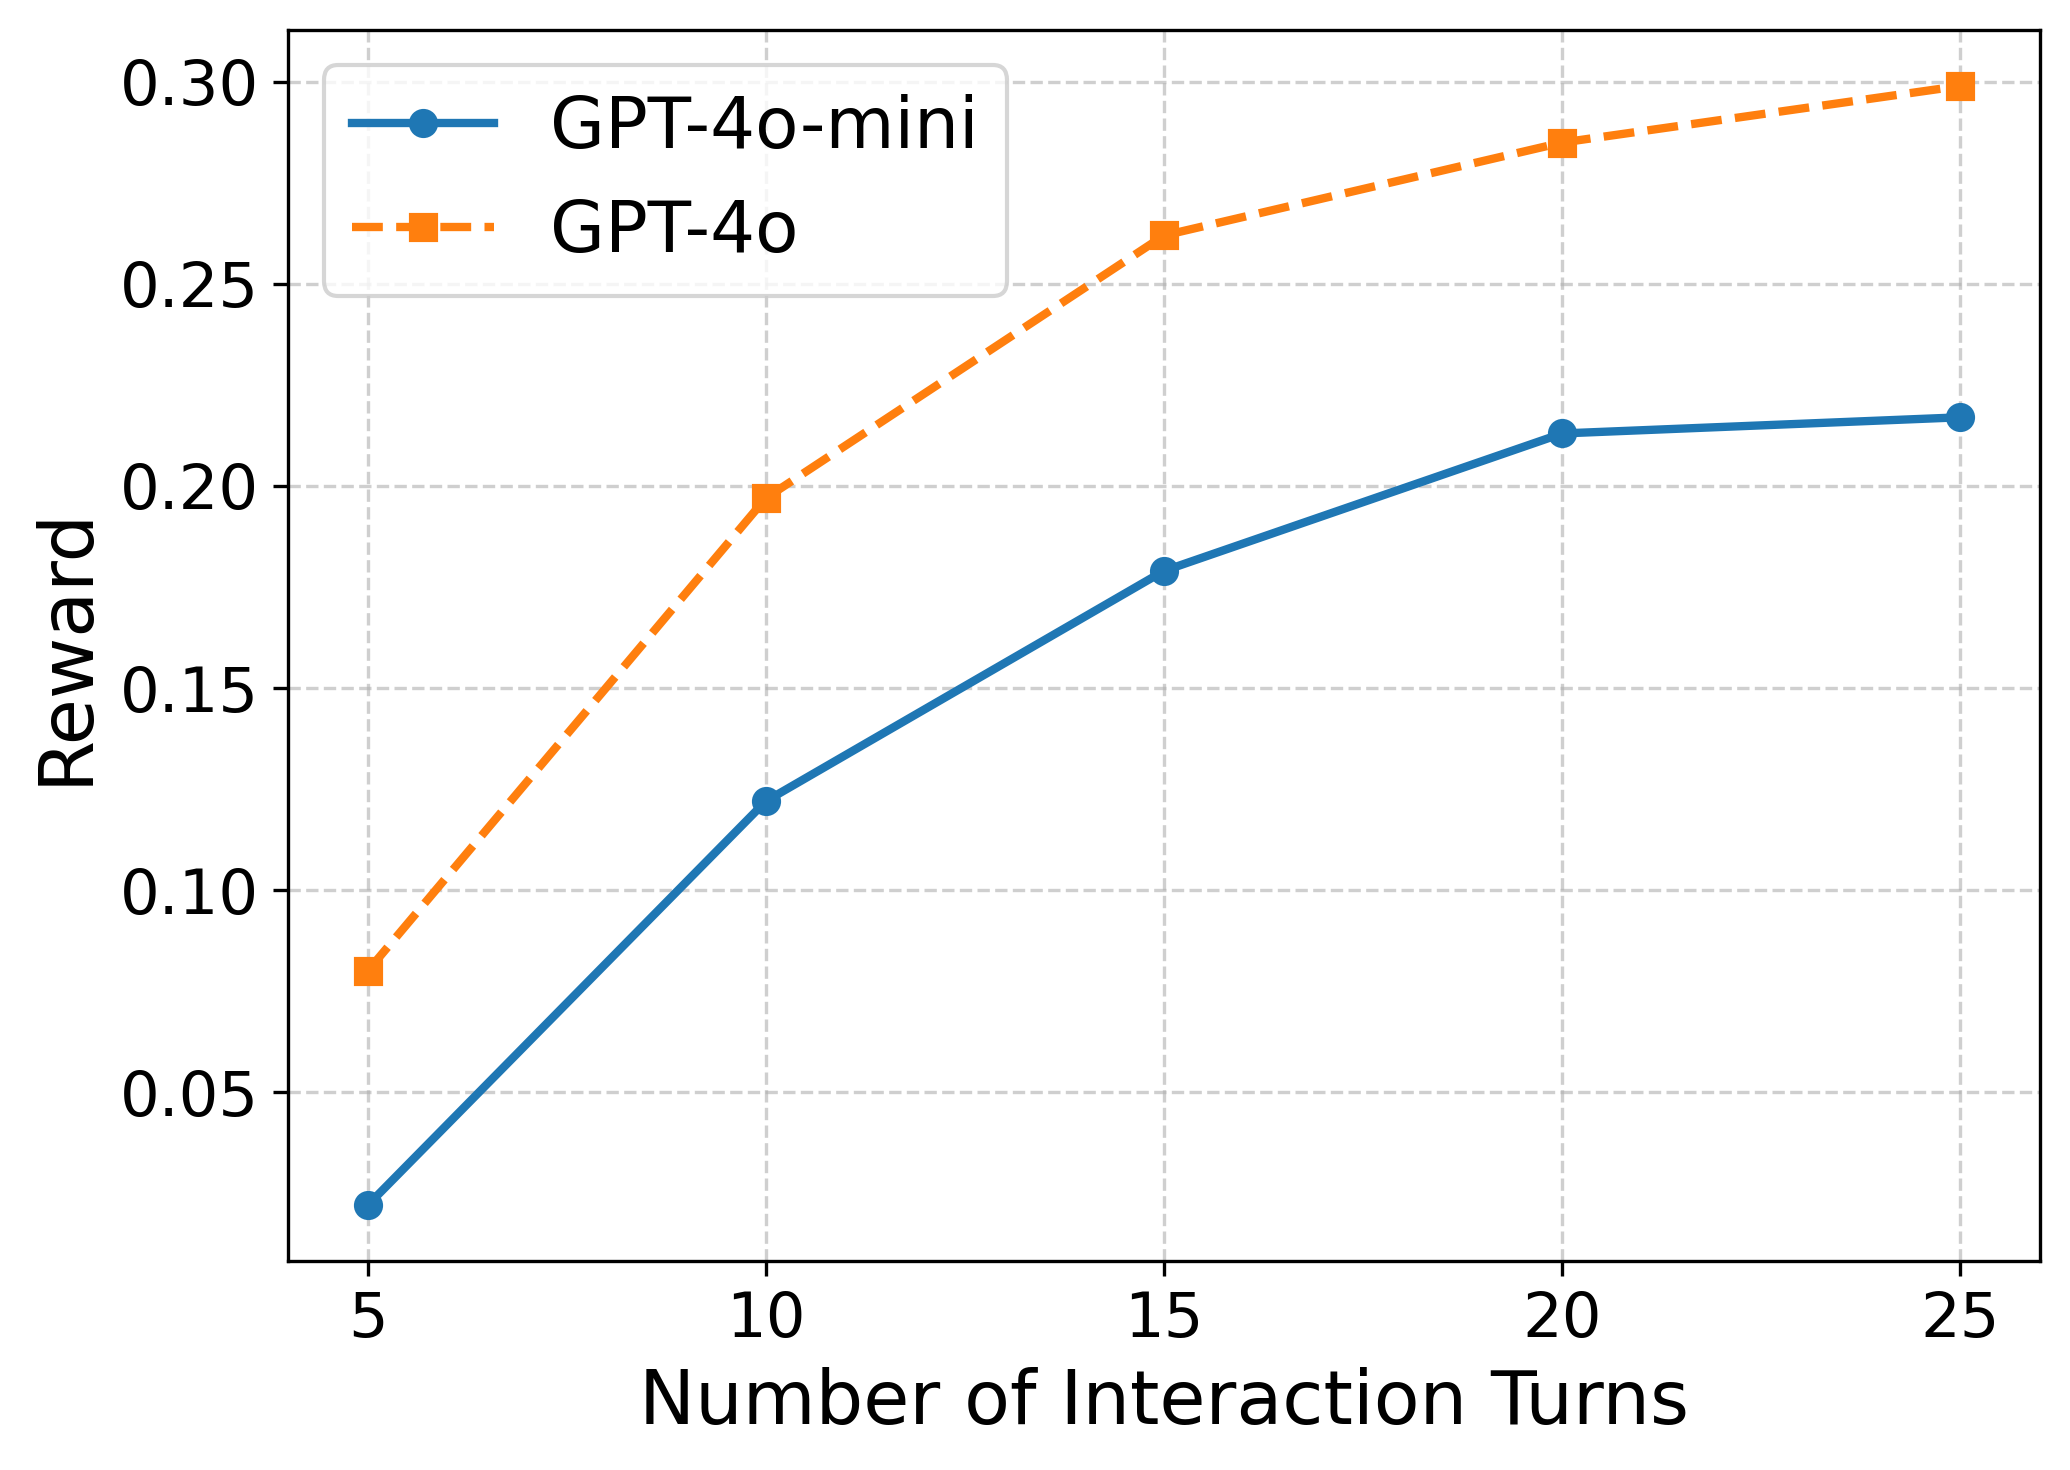

In [74]:
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt

def plot_turns_vs_reward(model_rewards: dict, steps: list, output_filename: str):
    """
    Plots the relation between the number of interaction turns and rewards for different models.

    Parameters:
    - model_rewards (dict): A dictionary where keys are model names and values are lists of rewards.
    - steps (list): A list of interaction turns (e.g., [5, 10, 15, 20, 25]).
    - output_filename (str): The filename for saving the output plot.
    """
    plt.figure(figsize=(7, 5), dpi=300)  # High-resolution figure

    markers = ['o', 's', 'D', '^', 'v', '*', 'P', 'X']  # Different markers for distinction
    linestyles = ['-', '--', '-.', ':']  # Variety of line styles
    colors = plt.get_cmap("tab10").colors  # Professional color palette

    for i, (model, rewards) in enumerate(model_rewards.items()):
        plt.plot(
            steps,
            rewards,
            marker=markers[i % len(markers)], 
            linestyle=linestyles[i % len(linestyles)], 
            color=colors[i % len(colors)],
            linewidth=2,
            markersize=6,
            label=model
        )

    plt.xlabel("Number of Interaction Turns", fontsize=18)
    plt.ylabel("Reward", fontsize=18)
    plt.xticks(steps, fontsize=15)  # Explicitly set x-ticks to given steps
    plt.yticks(fontsize=15)
    plt.legend(fontsize=17, loc="best", frameon=True)
    plt.grid(True, linestyle="--", alpha=0.6)

    plt.tight_layout()
    plt.savefig(output_filename, format="png", bbox_inches="tight", dpi=300)
    plt.show()
# Example usage:
model_rewards = {
    "GPT-4o-mini": gpt4omini_results,
    "GPT-4o": gpt40_results
}
steps = [5, 10, 15, 20, 25]
plot_turns_vs_reward(model_rewards, steps, "reward_vs_turns.png")

## Reward with respect to steps

In [80]:
def get_over_leaf_format_path_wise(log_path, file_folder, round_cut=-1):
    file_template = f"{log_path}/{file_folder}" + "/agent_incident_{0}.json"

    total_count = 0
    total_reward = 0
    total_success_count = 0
    total_cost = 0
    total_prompt_tokens = 0
    total_completion_tokens = 0

    accs_str = ""

    data_by_path_count = {}
    incidents = [5, 34, 38, 39, 55, 134, 166, 322]
    for i in incidents:
        # print(f"Analysis for incident {i}")
        with open(file_template.format(i), "r") as f:
            data = json.load(f)
        for d in data:
            p = len(d['question_dict']['shortest_alert_path'])
            if p not in data_by_path_count:
                data_by_path_count[p] = []
            data_by_path_count[p].append(d)

    keys = list(data_by_path_count.keys())
    keys.sort()

    count_str = ""
    for p in keys:
        data = data_by_path_count[p]
        count_str += f"& {len(data)} "
        result = analysis(data, False, round_cut=round_cut)
        accs_str += "& " + str(round(result['total_reward']/result['total_len'], 3)) + " "
        total_count += result['total_len']
        total_reward += result['total_reward']
        total_success_count += result['success_count']
        total_cost += result['total_cost']
        total_prompt_tokens += result['total_prompt_tokens']
        total_completion_tokens += result['total_completion_tokens']
    
    accs_str += "& " + str(round(total_reward/total_count, 3)) + " "
    accs_str += "& " + str(round(total_cost/total_count, 3)) + " "

    pl_str = ""
    for k in keys:
        pl_str += f"& {k} "
    
    print(pl_str)
    print(count_str)    

    print(accs_str)
    return round(total_reward/total_count, 3)

In [87]:
import os
import json
import shutil

# Define base directories
base = "/Users/kevin/Downloads/SecRL/secgym/env/questions/min_overlap/test"
new_base = "/Users/kevin/Downloads/SecRL/secgym/env/questions/min_overlap/test_filtered"

# Ensure new folder exists
os.makedirs(new_base, exist_ok=True)

removed_count = 0

for file in os.listdir(base):
    if file.endswith(".json"):
        file_path = os.path.join(base, file)

        with open(file_path, "r") as f:
            data = json.load(f)

        # Filter out questions with context < 50
        filtered_data = [q for i, q in enumerate(data) if len(q['context']) >= 50]

        # Remove question 9 if it's incident_9.json
        if file == "incident_9.json" and len(filtered_data) > 9:
            del filtered_data[9]  # Question 9 is index 9

        removed_count += len(data) - len(filtered_data)

        # Save to new folder
        new_file_path = os.path.join(new_base, file)
        with open(new_file_path, "w") as f:
            json.dump(filtered_data, f, indent=4)

print(f"Total questions removed: {removed_count}")
print(f"Filtered files saved to: {new_base}")

Total questions removed: 9
Filtered files saved to: /Users/kevin/Downloads/SecRL/secgym/env/questions/min_overlap/test_filtered


In [85]:
get_over_leaf_format_path_wise(log_path, "BaselineAgent_4o-mini_c71_alert_level_t0_s25_trial1", round_cut=25)

& 1 & 3 & 5 & 7 & 9 
& 46 & 423 & 98 & 31 & 1 
& 0.391 & 0.217 & 0.158 & 0.117 & 1.0 & 0.217 & 0.009 


0.217

In [86]:
get_over_leaf_format_path_wise(log_path, "BaselineAgent_gpt-4o_c70_alert_level_t0_s25_trial1", round_cut=25)

& 1 & 3 & 5 & 7 & 9 
& 46 & 423 & 98 & 31 & 1 
& 0.304 & 0.294 & 0.284 & 0.392 & 1.0 & 0.299 & 0.464 


0.299

In [83]:
get_over_leaf_format_path_wise(log_path, "PromptSauceAgent_4o-mini_c73_alert_level_t0_s25_trial1", round_cut=15)

& 1 & 3 & 5 & 7 & 9 
& 46 & 423 & 98 & 31 & 1 
& 0.217 & 0.253 & 0.228 & 0.196 & 1.0 & 0.244 & 0.016 


0.244

In [84]:
get_over_leaf_format_path_wise(log_path, "PromptSauceAgent_4o-mini_c79_alert_level_t0_s15_trial2", round_cut=15)

& 1 & 3 & 5 & 7 & 9 
& 46 & 423 & 98 & 31 & 1 
& 0.37 & 0.261 & 0.196 & 0.228 & 1.0 & 0.258 & 0.02 


0.258